In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,r2_score

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('AmesHousing.csv')
data = df.drop(['PID'], axis=1)

In [3]:
data = data.rename(columns={"MS SubClass": "MSSubClass", "MS Zoning": "MSZoning",'Lot Frontage':'LotFrontage', 'Lot Area':'LotArea',
       'Sale Condition':'SaleCondition','Yr Sold':'YrSold','YearBuilt': 'YearBuilt', 'Gr Liv Area': 'GrLivArea', 'Garage Area':'GarageArea',
       'Year Built':'YearBuilt','Pool Area':'PoolArea','Year Remod/Add':'YearRemodAdd','Garage Cars':'GarageCars','Total Bsmt SF':"TotalBsmtSF",
       "Full Bath":"FullBath","Mas Vnr Area":"MasVnrArea","1st Flr SF":"FstFlrSF","Garage Yr Blt":"GarageYrBlt","TotRms AbvGrd":"TotRmsAbvGrd",
       "Overall Qual":"OverallQual","Screen Porch":"ScreenPorch","Open Porch SF":"OpenPorchSF","Enclosed Porch":"EnclosedPorch",
       "Wood Deck SF":"WoodDeckSF","2nd Flr SF":"SndFlrSF","Bedroom AbvGr":"BedroomAbvGr","Kitchen AbvGr":"KitchenAbvGr",
})


Data cleaning

In [4]:
# create dummies
data['Fence'] = data['Fence'].notna()
data['Pool'] = data['PoolArea'] > 0


# Delete all data with MSZoning = commercial, agriculture and industrial as these are not residential units
data = data[(data.MSZoning != 'C (all)') & (data.MSZoning != 'I (all)') & (data.MSZoning != 'A (agr)')]

# Delete abnormal sales
data = data[(data.SaleCondition != 'Abnorml')] 
data = data[(data.SaleCondition != 'Family')] 

In [5]:
columns_to_keep=["YearBuilt","YearRemodAdd","Pool","Fence","ScreenPorch","OpenPorchSF","EnclosedPorch",
"WoodDeckSF","GarageArea","LotArea","TotalBsmtSF","FstFlrSF","SndFlrSF","GrLivArea","FullBath","BedroomAbvGr",
"KitchenAbvGr","TotRmsAbvGrd","Fireplaces","GarageCars","LotFrontage"]

In [6]:
# Select Features

X = data[columns_to_keep]
Y = data[['SalePrice']]

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=.3, random_state=1121218)

entrainement du model

In [8]:
numerical_features = X_train.select_dtypes(include='number').columns.tolist()
categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()

In [9]:
numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

In [10]:
from sklearn.compose import ColumnTransformer

full_processor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numerical_features),
    ('category', categorical_pipeline, categorical_features)
])

In [11]:
randomf = RandomForestRegressor()

randomf_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', randomf)
])

In [12]:
from sklearn.model_selection import GridSearchCV

param_dict = {'model__n_estimators': [350,400,450,500], 'model__bootstrap': [True,False]}

search = GridSearchCV(randomf_pipeline, param_dict, 
                      cv=10, 
                      scoring='neg_mean_absolute_error')

_ = search.fit(X_train, y_train)

print('Best score:', abs(search.best_score_))
print('Best params:', search.best_params_)


C:\Users\marie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\marie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\marie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\marie\AppData\Local\Programs\Python\Python310\lib\site-

Best score: 18297.63338995566
Best params: {'model__bootstrap': True, 'model__n_estimators': 350}


In [13]:
import pickle
filename = 'last_model.sav'
pickle.dump(search, open(filename, 'wb'))

Evaluation du modele

In [14]:
last_model = pickle.load(open("last_model.sav", 'rb'))

In [15]:
last_model.best_score_

-18297.63338995566

In [16]:
predict_on_Xtrain = last_model.predict(X_train)
predict_on_Xvalid = last_model.predict(X_valid)

In [17]:
mae_train = mean_absolute_error(y_train,predict_on_Xtrain)
mae_valid = mean_absolute_error(y_valid,predict_on_Xvalid)

In [18]:
print("EVALUATION DU MODELE GRACE A LA MAE (Mean Absolute Error)")
print("    ")
print("SUR LES DONNEES D'ENTRAINEMENT:")
print("Le modèle prédit une valeur exacte avec une erreure moyenne de {}$, ce qui est un delta acceptable sur le prix d'un bien immobilier".format(round(mae_train)))
print("    ")
print("SUR LES DONNEES DE VALIDATION:")
print("Le modèle prédit une valeur exacte et ce avec une erreure moyenne de {}$, ce qui est plus acceptable".format(round(mae_valid)))


EVALUATION DU MODELE GRACE A LA MAE (Mean Absolute Error)
    
SUR LES DONNEES D'ENTRAINEMENT:
Le modèle prédit une valeur exacte avec une erreure moyenne de 6773$, ce qui est un delta acceptable sur le prix d'un bien immobilier
    
SUR LES DONNEES DE VALIDATION:
Le modèle prédit une valeur exacte et ce avec une erreure moyenne de 18375$, ce qui est plus acceptable


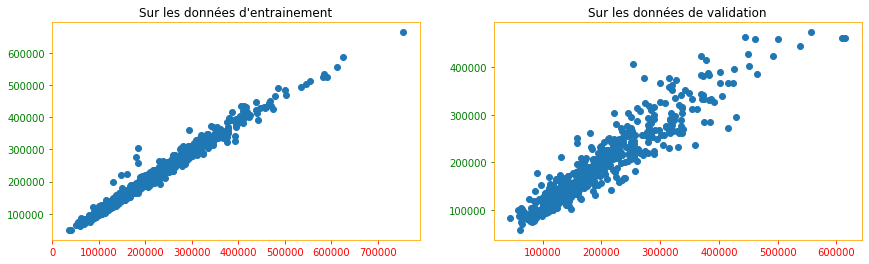

In [19]:
with plt.rc_context({'axes.edgecolor':'orange', 'xtick.color':'red', 'ytick.color':'green', 'figure.facecolor':'white'}):
    fig, (ax1, ax2) = plt.subplots(1,2)
    plt.subplots_adjust(right=2)

    ax1.scatter(y_train,predict_on_Xtrain)
    ax1.set_title("Sur les données d'entrainement")

    ax2.scatter(y_valid,predict_on_Xvalid)
    ax2.set_title("Sur les données de validation")